# Wildfires in the California: Weather data prepration

Author: Lena Berger

*Disclaimer: This project was done as part of a data science boot camp. All stakeholders mentioned are fictional. This study was not commissioned by any agency or stakeholder. The project makes use of fire data collected by Short (2017) and data provided by NOAA. Some of the findings presented in this document are based on a subsamples of these datasets and are not representative of and should not be generalized to the entire database without further due. Please contact the author previous to use or further distribution of the findings or analyses. The author does not take any responsibility or liability for consequences resulting from use of these analyses.*

This jupyter notebook creates the sample of California fire and weather data. The script assumes that the data has been obtained and is stored locally. We will work with a sample because of comuptational demands to identify and calculate weather data. With more computational power, this script can be extended to a larger sample including additional states. This script is prepared for obtaining the California data. The same script was used to get the Arizona data. For this the relevant_states_fire variable is set to "AZ" and the relevant_states_stations variable to "AZ" and its neighboring states. Otherwise, the script is identical. 

In [34]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import mpu
import seaborn as sns
from pyspark.sql import SparkSession

# Get the functions and dictionaries from the external file
exec(open("wildfires_functions_2020_07_26.py").read())

In [35]:
# Define the states that are relevant for this script
# We want fire data from CA. 
# For the weather data, we include neighboring states as a station in a neighboring state may be closer
# than a weather station in CA. 
relevant_states_fire = ["CA"]
relevant_states_stations = ["CA", "AZ", "NV", "OR"] # The relevant state plus neighboring states. 

In [47]:
# Open weather station data
weather_stations = pd.read_csv("data/weather stations 2020_07_06.csv", low_memory = False)
weather_stations['begin'] = pd.to_datetime(weather_stations['begin'], format = "%Y%m%d")
weather_stations['end'] = pd.to_datetime(weather_stations['end'], format = "%Y%m%d")

# Open the fire data
fire = pd.read_csv("data/fire data 2020_06_25.csv", low_memory = False, dtype={"FIPS_CODE": str})
fire['DISCOVERY_DATE'] = pd.to_datetime(fire['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
fire['CONT_DATE'] = pd.to_datetime(fire['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

In [48]:
# Open the weather data
# We will open each year and append it. 
# This will give us a dataset with all years. 

years = range(1991, 2016)

for i in tqdm(years): 
    path = "data/weather stations data {year} 2020_07_06.csv".format(year = str(i))
    df = pd.read_csv(path, low_memory = False, dtype={"stn": str})
    if i == min(years): 
        weather = df.copy()
    else: 
        weather = pd.concat([weather, df], axis = 0)

# Look at it
weather.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:44<00:00,  4.16s/it]


,stn,year,mo,da,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,flag_prcp
0,722909,1991,9,20,69.1,6.7,13.0,999.9,72.0,62.1,0.00,999.9,1,0,0,0,0,A
1,724620,1991,3,9,32.6,6.0,15.9,999.9,48.0,8.1,0.00,999.9,0,0,0,0,0,A
2,724920,1991,10,1,78.7,8.4,12.0,999.9,90.0,62.1,0.00,999.9,0,0,0,0,0,A
3,724620,1991,12,1,13.8,4.9,14.0,999.9,24.1,3.0,0.04,2.8,1,0,1,0,0,A
4,724920,1991,1,21,51.3,9.9,18.1,999.9,66.0,36.0,0.00,999.9,0,0,0,0,0,A


In [49]:
# Clean the weather data

# Temp
# No missing (9999.9)
weather.loc[weather["temp"] > 135, "temp"] = np.nan # Highest temp ever recorded in the US
weather.loc[weather["max"] > 135, "max"] = np.nan # Highest temp ever recorded in the US
weather.loc[weather["min"] > 135, "min"] = np.nan # Highest temp ever recorded in the US

# wdsp
weather = replace_missing(weather, "wdsp", 999.9)

# mxpsd
weather = replace_missing(weather, "mxpsd", 999.9)

# gust
# This variable is missing for about 50% of the data set.
weather = replace_missing(weather, "gust", 999.9)

# max
weather = replace_missing(weather, "max", 9999.9)

# min
weather = replace_missing(weather, "min", 9999.9) # Error fixed on July 15, 2020, needs rerun

# prcp
weather = replace_missing(weather, "prcp", 99.99) # This seemed to be wrong in the variable list. Fixed July 15, 2020

# sndp
# Official missing: 999.9
# However, 999.9 can also mean no snow. 
weather = replace_missing(weather, "sndp", 999.9)

# fog, rain_drizzle, snow_ice_pellets, hail, thunder
# Binary, no missings

# Combine the date variables (year, mo, da) into one variable. 
weather['date'] = pd.to_datetime(weather['year'].astype(str) + '-' + weather['mo'].astype(str) + '-' + weather['da'].astype(str))

In [50]:
weather.head()

,stn,year,mo,da,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,flag_prcp,date
0,722909,1991,9,20,69.1,6.7,13.0,NaN,72.0,62.1,0.00,NaN,1,0,0,0,0,A,1991-09-20
1,724620,1991,3,9,32.6,6.0,15.9,NaN,48.0,8.1,0.00,NaN,0,0,0,0,0,A,1991-03-09
2,724920,1991,10,1,78.7,8.4,12.0,NaN,90.0,62.1,0.00,NaN,0,0,0,0,0,A,1991-10-01
3,724620,1991,12,1,13.8,4.9,14.0,NaN,24.1,3.0,0.04,2.8,1,0,1,0,0,A,1991-12-01
4,724920,1991,1,21,51.3,9.9,18.1,NaN,66.0,36.0,0.00,NaN,0,0,0,0,0,A,1991-01-21


In [51]:
# Clean weather station data
# There are some stations that we do not have data for (e.g., stations closed before 1991). 
# We need to exclude them. 
no_data_for_station = list(set(list(weather_stations["usaf"])) - set(list(weather["stn"])))
weather_stations.drop(weather_stations[weather_stations["usaf"].isin(no_data_for_station)].index, inplace = True)

# Extract states
weather_stations = weather_stations[weather_stations["state"].isin(relevant_states_stations)].copy()

In [52]:
# Reduce fire data to only include fires in CA
fire = fire[fire["STATE"].isin(relevant_states_fire)].copy()

In [42]:
# Get a variable for big fires (cateogries D, E, F, & G)
fire["BIG_FIRE"] = 0
fire.loc[fire["FIRE_SIZE_CLASS"].isin(["D", "E", "F","G"]), "BIG_FIRE"] = 1

# Numnber of big fires
fire["BIG_FIRE"].sum()

4474

In [10]:
# We have 4474 big fires. We want to sample an equal amount of non-big fires. 
fire_big = fire[fire["BIG_FIRE"] == 1].copy()
fire_small = fire[fire["BIG_FIRE"] == 0].sample(4474, random_state = 42)

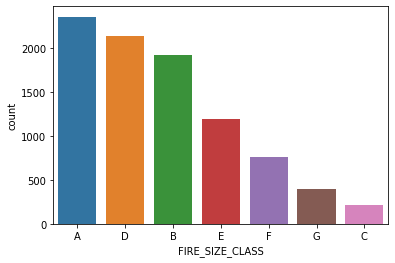

In [11]:
# Concat and look at fire representation
fire = pd.concat([fire_big, fire_small], axis =0)

sns.countplot(x="FIRE_SIZE_CLASS", 
              order = fire["FIRE_SIZE_CLASS"].value_counts().index,
              data = fire)


In [12]:
fire.shape

(8948, 26)

In [13]:
weather_stations.shape

(511, 11)

#### Weather variables
This section adds the weather information for the fires. We will include information on: 
* **Temperature**: Temperature (min, max, avg) on day of fire, 30 days prior to fire, and 60 days prior to fire
* **Rain**: Rain on day of fire, 30 days prior to fire, amd 60 days prior to fire and the time (days) since last rain (we also include the rain flag for future reference)
* **Wind**: Wind average and max speed on day of fire
* **Thunder**
* **Fog**
* **Snow**: Snow on day of fire and snow depth
* **Hail**

The variables ranging over longer time periods (e.g., 30 days prior to fire) represent means unless indicated otherwise. For a more detailed explanation of the variables, see variable desciption. 

In [14]:
# Look at weather stations
weather_stations.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
1,690020,93218,JOLON HUNTER LIGGETT MIL RES,US,CA,KHGT,36.000,-121.233,317.0,1964-07-15,1997-04-01
2,690020,99999,JOLON HUNTER LIGGETT MIL RES,US,CA,KHGT,36.000,-121.233,317.0,2003-07-02,2003-08-01
3,690070,93217,FRITZSCHE AAF,US,CA,KOAR,36.683,-121.767,43.0,1960-04-04,1993-08-31
5,690140,93101,EL TORO MCAS,US,CA,KNZJ,33.667,-117.733,116.7,1989-01-01,1999-06-30
6,690150,99999,TWENTYNINE PALMS,US,CA,KNXP,34.300,-116.167,626.0,1989-11-15,1989-12-29


In [15]:
# Create empty variables
fire["RAIN"] = np.nan
fire["RAIN_FLAG"] = np.nan
fire["RAIN_DIZZLE"] = np.nan
fire["AMOUNT_RAIN_30"] = np.nan
fire["AMOUNT_RAIN_60"] = np.nan
fire["DAYS_SINCE_LAST_RAIN"] = np.nan
fire["TEMP_AVG"] = np.nan
fire["TEMP_MIN"] = np.nan
fire["TEMP_MAX"] = np.nan
fire["TEMP_AVG_30"] = np.nan
fire["TEMP_MIN_AVG_30"] = np.nan
fire["TEMP_MAX_AVG_30"] = np.nan
fire["TEMP_AVG_60"] = np.nan
fire["TEMP_MIN_AVG_60"] = np.nan
fire["TEMP_MAX_AVG_60"] = np.nan
fire["THUNDER"] = np.nan
fire["FOG"] = np.nan
fire["SNOW"] = np.nan
fire["SNOW_DEPT"] = np.nan
fire["HAIL"] = np.nan
fire["WIND_AVERAGE"] = np.nan
fire["WIND_MAX"] = np.nan
fire["WIND_GUST"] = np.nan
fire["MISSING_DAT_CHECK"] = 0 # We will use this variable to check for problems. 

In [16]:
# Add the weather variables
for fire_ind in tqdm(fire.index): 
    
    # Find the active weather stations
    candidate_stations = weather_stations[(weather_stations["begin"] < 
                                          (fire.loc[fire_ind, "DISCOVERY_DATE"] - pd.DateOffset(years = 1))) & 
                                          (weather_stations["end"] > fire.loc[fire_ind, "DISCOVERY_DATE"]) & 
                                          (weather_stations["lat"].notnull()) & 
                                          (weather_stations["lon"].notnull())].index
     
    # Find the closest weather station
    close_list = closest(weather_stations.loc[candidate_stations, ["lat", "lon"]], 
                         fire.loc[fire_ind, ["LATITUDE", "LONGITUDE"]])

    
    empty = True
    
    while empty: 
        close = close_list.loc[close_list["distance"] == min(close_list["distance"]), "index"]
        close = close.iloc[0]
        
        # DATA: DAY OF FIRE
        
        weather_dat = weather.loc[(weather["stn"] == weather_stations.loc[close, "usaf"]) & 
                                  (weather['date'] == fire.loc[fire_ind, "DISCOVERY_DATE"])
                                 ]
        
        
        if ((weather_dat[["temp", "wdsp", "prcp", "max", "min"]].isnull().values.any()) | (weather_dat.empty)):
            close_list.drop(close_list[close_list["index"] == np.float(close)].index, inplace = True)
            
        else: 
            fire.loc[fire_ind, "RAIN"] = weather_dat["prcp"].values
            fire.loc[fire_ind, "RAIN_DIZZLE"] = weather_dat["rain_drizzle"].values
            fire.loc[fire_ind, "TEMP_AVG"] = weather_dat["temp"].values
            fire.loc[fire_ind, "TEMP_MIN"] = weather_dat["min"].values
            fire.loc[fire_ind, "TEMP_MAX"] = weather_dat["max"].values
            fire.loc[fire_ind, "THUNDER"] = weather_dat["thunder"].values
            fire.loc[fire_ind, "FOG"] = weather_dat["fog"].values
            fire.loc[fire_ind, "SNOW"] = weather_dat["snow_ice_pellets"].values
            fire.loc[fire_ind, "SNOW_DEPT"] = weather_dat["sndp"].values
            fire.loc[fire_ind, "HAIL"] = weather_dat["hail"].values
            fire.loc[fire_ind, "WIND_AVERAGE"] = weather_dat["wdsp"].values
            fire.loc[fire_ind, "WIND_MAX"] = weather_dat["mxpsd"].values
            fire.loc[fire_ind, "WIND_GUST"] = weather_dat["gust"].values
            fire.loc[fire_ind, "RAIN_FLAG"] = weather_dat["flag_prcp"].values
            empty = False

        
    # DATA: 30 DAYS BEFORE FIRE
    # We make an assumption here that this weather station also reported valid data for previous months. 
    # We will check this assumption with the MISSING_DAT_CHECK variable. 
        
    # Get and and starting data
    end = fire.loc[fire_ind, "DISCOVERY_DATE"]
    start = end - pd.DateOffset(days = 30)
    
    # Get the relevant weather data info
    weather_dat_prev = weather.loc[(weather["stn"] == weather_stations.loc[close, "usaf"]) & 
                                   (weather['date'] >= start) &
                                   (weather['date'] <= end)]
    
    if ((weather_dat_prev[["temp", "prcp", "max", "min"]].isnull().values.any()) | (weather_dat.empty)):
        fire["MISSING_DAT_CHECK"] == 1
    
    fire.loc[fire_ind, "TEMP_AVG_30"] = weather_dat_prev["temp"].mean()
    fire.loc[fire_ind, "TEMP_MIN_AVG_30"] = weather_dat_prev["max"].mean()
    fire.loc[fire_ind, "TEMP_MAX_AVG_30"] = weather_dat_prev["min"].mean()
    fire.loc[fire_ind, "AMOUNT_RAIN_30"] = weather_dat_prev["prcp"].sum()
    
    # DATA: 60 DAYS BEFORE FIRE
    # We make an assumption here that this weather station also reported valid data for previous months. 
    # We will check this assumption with the MISSING_DAT_CHECK variable. 
        
    # Get and and starting data
    end = fire.loc[fire_ind, "DISCOVERY_DATE"]
    start = end - pd.DateOffset(days = 90)
    
    # Get the relevant weather data info
    weather_dat_prev = weather.loc[(weather["stn"] == weather_stations.loc[close, "usaf"]) & 
                                   (weather['date'] >= start) &
                                   (weather['date'] <= end)]
    
    if ((weather_dat_prev[["temp", "prcp", "max", "min"]].isnull().values.any()) | (weather_dat.empty)):
        fire["MISSING_DAT_CHECK"] == 1
    
    fire.loc[fire_ind, "TEMP_AVG_60"] = weather_dat_prev["temp"].mean()
    fire.loc[fire_ind, "TEMP_MIN_AVG_60"] = weather_dat_prev["max"].mean()
    fire.loc[fire_ind, "TEMP_MAX_AVG_60"] = weather_dat_prev["min"].mean()
    fire.loc[fire_ind, "AMOUNT_RAIN_60"] = weather_dat_prev["prcp"].sum()
    
    # DATA: LAST PERCIPITATION
    weather_dat_last_perc = weather.loc[((weather["stn"] == weather_stations.loc[close, "usaf"]) & 
                                       (weather['date'] <= end))]
    
    fire.loc[fire_ind, "DAYS_SINCE_LAST_RAIN"] = (fire.loc[fire_ind, "DISCOVERY_DATE"] - weather_dat_last_perc.loc[weather_dat_last_perc["prcp"] > 0, 'date'].max()).days
    

100%|███████████████████████████████████████████████████████████████████████████| 8948/8948 [12:39:27<00:00,  5.09s/it]


In [17]:
# Save a copy of this. 
fire.to_csv('data/fire data safety copy 1 adding weather data 2020_07_25.csv', index=False)

#### Additional fire variables
We want to add three additional fire variables: 
1. **Time until containment**: This is the time from when the fire was discoverd until it was contained (i.e., under controll)
2. **Simultaneous fires**: Number of fires that roughly burn at the same time. 
3. **Close fires**: Number of fires over the past three years that were close and their size. 

In [22]:
# # Get the time until containment
fire["TIME_TO_CONTAIN"] = (fire["CONT_DATE"] - fire["DISCOVERY_DATE"]).dt.days

In [23]:
# We want to know how many fires are burning at the same time. 
# We know that there is considerable amount of error in the contamination dates. 
# We also know that most fires are contaminated within one day. 
# So, we will use two proxies here. Namely, the number of fires that are discovered plus minus one day 
# of the discovery of our target fire and plus minus 3 days. 
fire["SIMULTANEOUS_FIRE_ONE_DAY"] = np.nan
fire["SIMULTANEOUS_FIRE_THREE_DAYS"] = np.nan

In [24]:
# Get the data
for fire_ind in tqdm(fire.index):  
    
    # Determine for each fire if it was active during the time the fire was burning
    active_1 = 0 # Count variable for fires active +- 1 day
    active_3 = 0 # Count variable for fires active +- 3 days
    
    for fire_ind_2 in fire.index:
        if ((fire.loc[fire_ind_2, "DISCOVERY_DATE"] >= (fire.loc[fire_ind, "DISCOVERY_DATE"] - 
                                                                     pd.DateOffset(days = 1))) &
            (fire.loc[fire_ind_2, "DISCOVERY_DATE"] <= (fire.loc[fire_ind, "DISCOVERY_DATE"] + 
                                                                     pd.DateOffset(days = 1)))): 
            active_1 += 1
        
        if ((fire.loc[fire_ind_2, "DISCOVERY_DATE"] >= (fire.loc[fire_ind, "DISCOVERY_DATE"] - 
                                                                     pd.DateOffset(days = 3))) &
            (fire.loc[fire_ind_2, "DISCOVERY_DATE"] <= (fire.loc[fire_ind, "DISCOVERY_DATE"] + 
                                                                     pd.DateOffset(days = 3)))):
            active_3 += 1
    
    fire.loc[fire_ind, "SIMULTANEOUS_FIRE_ONE_DAY"] = active_1 - 1 # We do not want to count this fire. 
    fire.loc[fire_ind, "SIMULTANEOUS_FIRE_THREE_DAYS"] = active_3 - 1 # We do not want to count this fire. 


100%|████████████████████████████████████████████████████████████████████████████| 8948/8948 [6:44:14<00:00,  2.71s/it]


In [25]:
fire.head()

,FOD_ID,FPA_ID,FIRE_CODE,FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,...,SNOW,SNOW_DEPT,HAIL,WIND_AVERAGE,WIND_MAX,WIND_GUST,MISSING_DAT_CHECK,TIME_TO_CONTAIN,SIMULTANEOUS_FIRE_ONE_DAY,SIMULTANEOUS_FIRE_THREE_DAYS
0,17,FS-1418878,NaN,POWER,NaN,2004,2004-10-06,280,1415.0,2.0,...,0.0,NaN,0.0,2.9,10.1,NaN,0,15.0,2.0,6.0
1,18,FS-1418881,BHA3,FREDS,NaN,2004,2004-10-13,287,1618.0,2.0,...,0.0,NaN,0.0,5.1,15.9,21.0,0,4.0,4.0,9.0
2,556,FS-1420078,BZS6,NINE,NaN,2005,2005-07-09,190,1313.0,9.0,...,0.0,NaN,0.0,9.2,18.1,NaN,0,1.0,9.0,18.0
3,1514,FS-1422180,BE0C,BARRETT,NaN,2005,2005-08-24,236,1110.0,4.0,...,0.0,NaN,0.0,6.1,13.0,16.9,0,2.0,4.0,19.0
4,2740,FS-1424833,B6NE,CLOVER,NaN,2005,2005-09-16,259,1435.0,9.0,...,0.0,NaN,0.0,3.6,14.0,25.1,0,2.0,7.0,11.0


In [26]:
# Save the data. 
fire.to_csv('data/fire data safety copy 2 adding fire data part 1 2020_07_25.csv', index=False)

In [27]:
# Finally, we would like to know how many other fires have been in the area in the last 3 years and
# how much they burnt. 
fire["CLOSE_FIRES_THREE_YEARS"] = np.nan
fire["CLOSE_FIRES_THREE_YEARS_AREA_BURNT"] = np.nan

In [28]:
# Do the calculations
for fire_ind in tqdm(fire.index):  
    
    # All fires before 1994 should be excluded because there is no 3 year of data prior to their discovery. 
    if (fire.loc[fire_ind, "DISCOVERY_DATE"].year > 1994): 
        
        # Determine for each fire if it was active during the time the fire was burning
        close_fires = np.nan
        acres_burnt = np.nan

        # Find relevant fires
        relevant = list(fire[(fire["DISCOVERY_DATE"] >= (fire.loc[fire_ind, "DISCOVERY_DATE"] -
                                                     pd.DateOffset(years = 3))) &
                             (fire["DISCOVERY_DATE"] <= fire.loc[fire_ind, "DISCOVERY_DATE"])].index)

        # Remove index of current fire
        relevant.remove(fire_ind)

        if relevant: 

            # Get distance to current fire
            dist_fire = closest(fire.loc[relevant, ["LATITUDE", "LONGITUDE"]], 
                                fire.loc[fire_ind, ["LATITUDE", "LONGITUDE"]])

            # Get fire roughly closer than 5km^2
            close_fires = dist_fire[dist_fire["distance"] <= 5].shape[0]
            acres_burnt = fire.loc[dist_fire.loc[dist_fire["distance"] <= 5, "index"], "FIRE_SIZE"].sum()

            fire.loc[fire_ind, "CLOSE_FIRES_THREE_YEARS"] = close_fires 
            fire.loc[fire_ind, "CLOSE_FIRES_THREE_YEARS_AREA_BURNT"] = acres_burnt 
    

100%|██████████████████████████████████████████████████████████████████████████████| 8948/8948 [10:39<00:00, 13.99it/s]


In [29]:
# Look at the data
fire.head()

,FOD_ID,FPA_ID,FIRE_CODE,FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,...,HAIL,WIND_AVERAGE,WIND_MAX,WIND_GUST,MISSING_DAT_CHECK,TIME_TO_CONTAIN,SIMULTANEOUS_FIRE_ONE_DAY,SIMULTANEOUS_FIRE_THREE_DAYS,CLOSE_FIRES_THREE_YEARS,CLOSE_FIRES_THREE_YEARS_AREA_BURNT
0,17,FS-1418878,NaN,POWER,NaN,2004,2004-10-06,280,1415.0,2.0,...,0.0,2.9,10.1,NaN,0,15.0,2.0,6.0,0.0,0.00
1,18,FS-1418881,BHA3,FREDS,NaN,2004,2004-10-13,287,1618.0,2.0,...,0.0,5.1,15.9,21.0,0,4.0,4.0,9.0,0.0,0.00
2,556,FS-1420078,BZS6,NINE,NaN,2005,2005-07-09,190,1313.0,9.0,...,0.0,9.2,18.1,NaN,0,1.0,9.0,18.0,3.0,691.35
3,1514,FS-1422180,BE0C,BARRETT,NaN,2005,2005-08-24,236,1110.0,4.0,...,0.0,6.1,13.0,16.9,0,2.0,4.0,19.0,2.0,0.20
4,2740,FS-1424833,B6NE,CLOVER,NaN,2005,2005-09-16,259,1435.0,9.0,...,0.0,3.6,14.0,25.1,0,2.0,7.0,11.0,0.0,0.00


In [30]:
# Check the missing data variable
fire["MISSING_DAT_CHECK"].value_counts()

0    8948
Name: MISSING_DAT_CHECK, dtype: int64

In [31]:
# Save the data. 
fire.to_csv('data/fire data updated 2020_07_25.csv', index=False)

#### Weather data for California
Finally, we will save the weather data from all stations in California for the time 1992 to 2015. 

In [53]:
# One station is miscoded, get rid of it
weather_stations.drop(index = weather_stations[weather_stations['lat'] < 10].index, inplace = True) 
weather_stations = weather_stations[weather_stations["state"] == "CA"].copy()

In [55]:
# Get the data
CA_weather_data = weather.loc[(weather["stn"].isin(weather_stations["usaf"])) & 
                              (weather['year'] >= 1992) &
                              (weather['year'] <= 2015)].copy()

In [56]:
# Save the data. 
CA_weather_data.to_csv('data/CA weather data 2020_07_25.csv', index=False)